In [63]:
import jax
from jax import numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from energax.sampling import continuous
from energax import losses
from energax.ebms import nn_ebms

# from tqdm.notebook import tqdm

In [87]:
import tensorflow_datasets as tfds
import numpy as np


# adapted from: https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html
data_dir = "/tmp/tfds"

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(
    name="mnist", batch_size=-1, data_dir=data_dir, with_info=True
)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data["train"], mnist_data["test"]
num_labels = info.features["label"].num_classes
h, w, c = info.features["image"].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data["image"], train_data["label"]

train_labels = jnp.array(train_labels).astype("int8")
# Full test set
test_images, test_labels = test_data["image"], test_data["label"]

train_labels = jnp.array(test_labels).astype("int8")
# Convert train_labels and test_labels to one-hot encodings
train_labels = jax.nn.one_hot(train_labels, num_classes=num_labels).astype("int8")
test_labels = jax.nn.one_hot(test_labels, num_classes=num_labels).astype("int8")

In [88]:
train_images = jnp.array(jnp.reshape(train_images,(train_images.shape[0], 28, 28)))/255.0
test_images = jnp.array(jnp.reshape(test_images,(test_images.shape[0], 28, 28)))/255.0

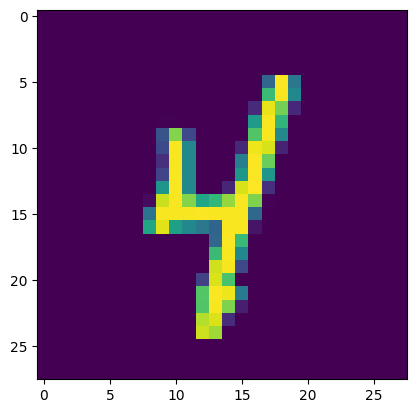

In [90]:
plt.imshow(train_images[0])

In [91]:
key = jax.random.PRNGKey(42)

In [92]:
class ClassConditionCNN(eqx.Module):
    layers: list
    class_layer: eqx.nn.Linear
    n_class: int

    def __init__(self, key, outputs=1, hidden_features=32, n_classes=10) -> None:
        if not isinstance(hidden_features, int):
            raise TypeError("hidden_features must be an integer")
        chid1 = hidden_features // 2
        chid2 = hidden_features
        chid3 = hidden_features * 2

        keys = jax.random.split(key, 7)

        self.layers = [
            eqx.nn.Conv2d(2, chid1, kernel_size=5, stride=2, padding=4, key=keys[0]),
            jax.nn.swish,
            eqx.nn.Conv2d(
                chid1, chid2, kernel_size=3, stride=2, padding=1, key=keys[1]
            ),
            jax.nn.swish,
            eqx.nn.Conv2d(
                chid2, chid3, kernel_size=3, stride=2, padding=1, key=keys[2]
            ),
            jax.nn.swish,
            eqx.nn.Conv2d(
                chid3, chid3, kernel_size=3, stride=2, padding=1, key=keys[3]
            ),
            jax.nn.swish,
            lambda x: x.flatten(),
            eqx.nn.Linear(chid3 * 4, chid3, key=keys[4]),
            jax.nn.swish,
            eqx.nn.Linear(chid3, outputs, key=keys[5]),
        ]
        self.class_layer = eqx.nn.Linear(n_classes, 28, key=keys[6])
        self.n_class = n_classes

    def __call__(self, x, class_=None):
        if class_ is None:
            x, class_ = x
        x = jnp.expand_dims(x, axis=0)  # (28, 28) -> (1, 28, 28) where 1 is # channels
        y = self.class_layer(class_) * jnp.ones((1, 28, 28))
        x = jnp.concatenate((x, y), axis=0)
        for l in self.layers:
            x = l(x)
        return jnp.squeeze(x)

In [93]:
batch_size = 128
key, subkey = jax.random.split(key)
ebm = nn_ebms.ContinuousNNEBM(ClassConditionCNN(subkey))
loss_fn = lambda model, r, f: losses.contrastive_divergence(model, r, f, 0.1)
samp = continuous.LangevinSampler(
    (28, 28),
    num_chains=batch_size,
    minval=-1.0,
    maxval=1.0,
    stepsize=10.0,
    sigma=0.005,
    num_langevin_steps=100,
    sample_clip=1.0,
)

In [94]:
# nsteps = len(train_images) // batch_size * 60
nsteps = 2
data = 2 * jnp.array(train_images) - 1.0
max_images = len(data)
sample_fn = eqx.filter_jit(samp.sample_chains)

In [95]:
adam = optax.adam(1e-4)
optimizer = optax.chain(adam, optax.clip_by_global_norm(0.997))
opt_state = optimizer.init(eqx.filter(ebm, eqx.is_array))

In [96]:
value_and_grad_fct = eqx.filter_jit(eqx.filter_value_and_grad(loss_fn))


@eqx.filter_jit
def step(model, data_input, samples, opt_state):
    value, grads = value_and_grad_fct(model, data_input, samples)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, value, opt_state


@eqx.filter_jit
def inner_loop(model, opt_state, key):
    subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 4)
    classes = jax.nn.one_hot(
        jax.random.randint(subkey1, minval=0, maxval=10, shape=(batch_size,)), 10
    )
    ebm_samples = sample_fn(model, None, subkey2, class_=classes)["position"]
    indices = jax.random.choice(
        subkey3, jnp.arange(max_images), shape=(batch_size,), replace=False
    )
    data_input = (
        jax.random.normal(subkey4, (batch_size, 28, 28)) * 0.005 + data[indices],
        train_labels[indices],
    )
    ebm_samples = (ebm_samples, classes)
    model, value, opt_state = step(model, data_input, ebm_samples, opt_state)
    return model, opt_state, value

In [97]:
loss = []

# for j in tqdm(range(nsteps)):
for j in range(nsteps):
    key, subkey = jax.random.split(key)
    ebm, opt_state, value = inner_loop(ebm, opt_state, subkey)
    loss.append(value)

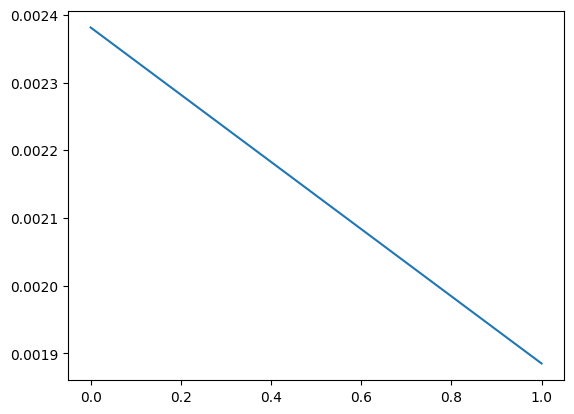

In [98]:
plt.plot(loss)
plt.show()

(4, 28, 28)


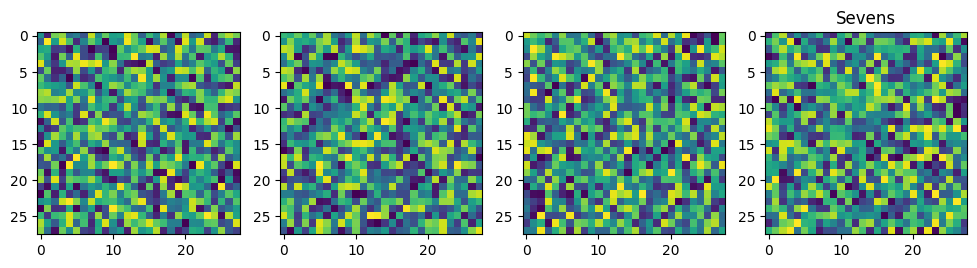

In [99]:
key, subkey = jax.random.split(key, 2)
inference_sampler = continuous.LangevinSampler(
    (28, 28),
    num_chains=4,
    minval=-1.0,
    maxval=1.0,
    stepsize=10.0,
    sigma=0.00,
    num_langevin_steps=260,
    sample_clip=1.0,
)
inference_fn = eqx.filter_jit(inference_sampler.sample_chains)
samples = inference_fn(
    ebm, None, subkey, class_=jax.nn.one_hot(jnp.array([1, 2, 3, 4]), 10)
)["position"]
print(samples.shape)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(samples[i])

plt.title("Sevens")
plt.show()